<a href="https://colab.research.google.com/github/fantasydatapros/2021-VOR-Model/blob/master/BattingAverageVarianceAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fantasy Data Pros Introduction

My name is Ben Dominguez and I'm the founder of Fantasy Data Pros. 

<a href="https://www.fantasydatapros.com">Fantasy Data Pros</a> is a platform for people to turn their obsession for sports into programming and data science skills. We teach programming and data science fundamentals all through sports, and offer a free tutorial series for each of the 5 major sports (<a href="https://www.fantasydatapros.com/baseball/blog">link to our free baseball series here</a>, we'll be coming out with many more posts in the coming months) and a couple online courses, including a <a href="https://www.fantasydatapros.com/baseball">Learn Python with Baseball course</a>. In the Learn Python with Baseball course, we offer 11 learning modules, 7 hours of video content, and an online community of 300+ other members learning to code. You can use the code F6P for $15 off today!

# Analyzing Projected Batting Averages

In this post, we're going to be showing you the power of Python and advanced data analytics by looking at projected batting averages
from 4 different sources for the upcoming MLB season. We're interested in seeing which players have the highest/lowest variance with respect to their projected batting averages. This can be valuable information for season long fantasy drafts since variance gives us insight into how confident we can be in a player's projected production (in this case, batting average). In general, players with lower variance suggest we should have higher confidence in their projections coming to fruition, while players with higher variance among their projections could be classified as more risky. Lets get started by reading in our data and combining it into a pandas DataFrame for analysis.  

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings; warnings.simplefilter('ignore')

# Read in projection sources 
atc = pd.read_csv("https://raw.githubusercontent.com/fantasydatapros/fangraph-data-f6p/main/atcBats.csv")
batx = pd.read_csv("https://raw.githubusercontent.com/fantasydatapros/fangraph-data-f6p/main/batxBats.csv")
steamer = pd.read_csv("https://raw.githubusercontent.com/fantasydatapros/fangraph-data-f6p/main/steamerBats.csv")
zips = pd.read_csv("https://raw.githubusercontent.com/fantasydatapros/fangraph-data-f6p/main/zipsBats.csv")

# Create a list of columns we want to look at that are related to batting average
stats = ['AVG']

# List of player descriptive columns
player_info = ['Name','PlayerId','Team']

# Filter out columns we won't be using
atc = atc[player_info+stats]
batx = batx[player_info+stats]
steamer = steamer[player_info+stats]
zips = zips[player_info+stats]
# 
# We'll need to combine the projection sources into one data frame, but
# before we do that we'll need to give each stat projection a unique column name

# Loop through each stat and give it a new name that corresponds to the projection source
for stat in stats:
  atc.rename({stat:f'atc_proj_{stat}'}, axis=1, inplace=True)
  batx.rename({stat:f'batx_proj_{stat}'}, axis=1, inplace=True)
  steamer.rename({stat:f'steamer_proj_{stat}'}, axis=1, inplace=True)
  zips.rename({stat:f'zips_proj_{stat}'}, axis=1, inplace=True)

# Combine stats into one data frame
df = atc.merge(
    batx,on=player_info,how='left'
    ).merge(
    steamer,on=player_info,how='left'
    ).merge(
    zips,on=player_info,how='left')

# Determine mean projected batting average for each player
df['avg_proj_AVG'] = df[['atc_proj_AVG','batx_proj_AVG', 'steamer_proj_AVG','zips_proj_AVG']].mean(axis=1)

# Round batting averages to 3 decimal places
df = df.round(3)

# Determine variance among player projections
df['proj_variance'] = df[['atc_proj_AVG','batx_proj_AVG', 'steamer_proj_AVG','zips_proj_AVG']].var(axis=1)

# Sort data frame by average projected averages
df.sort_values(by='avg_proj_AVG',ascending=False,inplace=True)

df.head(5)

,Name,PlayerId,Team,atc_proj_AVG,batx_proj_AVG,steamer_proj_AVG,zips_proj_AVG,avg_proj_AVG,proj_variance
52,Luis Arraez,18568,MIA,0.302,0.296,0.297,0.311,0.301,0.000047
7,Freddie Freeman,5361,LAD,0.301,0.299,0.292,0.293,0.296,0.000020
83,Masataka Yoshida,31837,BOS,0.286,0.282,0.299,0.305,0.293,0.000117
8,Trea Turner,16252,PHI,0.292,0.286,0.283,0.301,0.291,0.000063
16,Vladimir Guerrero Jr.,19611,TOR,0.289,0.296,0.293,0.284,0.290,0.000027


So now we have a DataFrame that contains projections for 2023 batting averages from 4 separate projection sources. Additionally, we have the variance associated with the projections for each player. Suppose we're getting ready for a season long fantasy draft, if we wanted to prioritize projected batting averages as the most important statistic when drafting, we want to be confident that the batting average we're projecting for each player pans out. So essentially when we're looking at available players we want to see a high projected batting average with a low variance. Since we're interested in drafting good players, lets filter out players with an average projected batting averages less than .250. After that we'll sort our DataFrame by projection variance so we can see which players have the highest variance with respect to their projected batting average.

<Figure size 432x288 with 0 Axes>

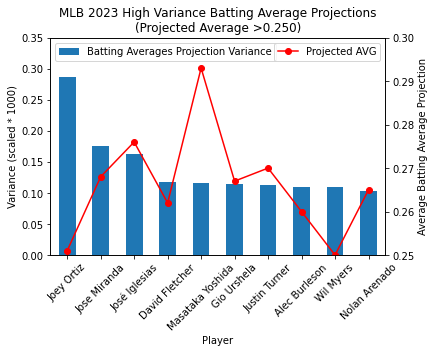

In [17]:
df = df[df.avg_proj_AVG >= 0.250]
df.sort_values(by='proj_variance', ascending=False, inplace=True)

#Plot Top 10 Players With Highest Battinv Average Projection Variance
temp = df.copy()

# Scale Variance column by 1000
temp.proj_variance *= 1000

# Rename proj_variance column to something more descriptive for our visual
# Also rename Name to Player
temp.rename({
      'proj_variance': 'Batting Averages Projection Variance',
      'Name': 'Player'
    }, axis=1, inplace=True)

# Make a bar plot for variance
fig = plt.figure()
ax = temp.head(10).plot.bar('Player','Batting Averages Projection Variance')
plt.xticks(rotation=45)
plt.title('MLB 2023 High Variance Batting Average Projections\n(Projected Average >0.250)')
ax.set_ylabel('Variance (scaled * 1000)')
ax.set_ylim(0, 0.35)

# Overlay Projected Batting Averages
ax2 = ax.twinx()
ax2.plot(temp.head(10).Player, temp.head(10).avg_proj_AVG, color="red", marker="o")
ax2.set_ylabel("Average Batting Average Projection")
ax2.set_ylim(0.250, 0.300)
ax2.legend(['Projected AVG'], loc='upper right')
ax.legend(loc='upper left');

In the plot above, we're looking at the 10 players with the highest variance among their batting average projections. We see Joey Ortiz as the player with the highest variance. This comes to no surprise since Joey Ortiz is a prospect for The Baltimore Orioles and has not yet played a full MLB season, thus it makes sense there would be a high degree of variance in his projeced batting average. If we move further down the list we can see names like Jose Miranda and Jose Iglesias, each of who are in the top 3 highest variance players. With solid projected batting averages greater than 0.270, these would be decent players to have on our season long fantasy squad, but we would urge caution with these players given the high variance in their projections. Lets take a closer look at Jose Iglesias and his career statistics.

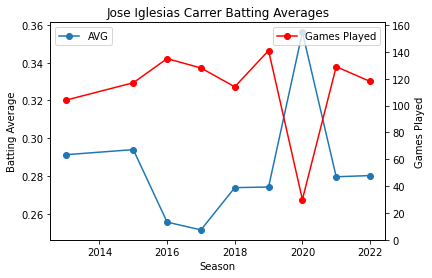

In [18]:
# Read in jose iglesias game data
import numpy as np
ji = pd.read_csv("https://raw.githubusercontent.com/fantasydatapros/fangraph-data-f6p/main/jose_iglesias.csv")
ji.sort_values(by='game_date',inplace=True)
temp = ji.groupby('season', as_index=False).agg({
            'hits': np.sum,
            'atBats': np.sum,
            'AVG': np.mean,
            'gamesPlayed': np.sum
})

ax = temp.plot('season', 'AVG', marker='o')
ax.set_ylabel('Batting Average')
ax.set_xlabel('Season')
ax.set_title('Jose Iglesias Carrer Batting Averages')
ax2 = ax.twinx()
ax2.plot(temp.season, temp.gamesPlayed,color="red", marker="o")
ax2.set_ylabel("Games Played")
ax2.set_ylim(0,162)
ax2.legend(['Games Played'], loc='upper right')
ax.legend(loc='upper left');

Jose Iglesias has had some up and down years between 2013 and 2018, but since then has seen his average steadily hover around the 0.275-0.280 range. So why the high variance in the projections? It could be that some projections weigh recent years more heavily, while others weigh some of the down years he had early in his career equally. This can result in a wider range of projections. For fun, lets look at how his 40 game moving average compares to his 162 game moving average. We'd expect volatile players to have more hot/cold streaks, thus their 40 game moving average would deviate further away from their 162 game moving average. 

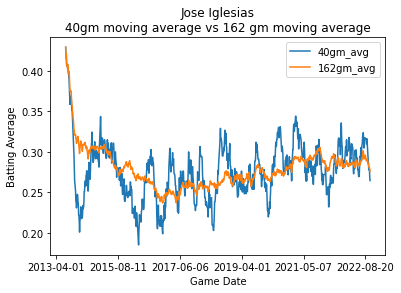

In [19]:
ji['162gm_avg'] = ji.AVG.rolling(window=162, min_periods=30).mean()
ji['40gm_avg'] = ji.AVG.rolling(window=40, min_periods=30).mean()
ax=ji.plot('game_date', ['40gm_avg','162gm_avg'])
ax.set_title('Jose Iglesias\n40gm moving average vs 162 gm moving average')
ax.set_ylabel('Batting Average')
ax.set_xlabel('Game Date');

Throughout his career Iglesias has had shown some volatility in his batting average with respect to his long term average. This may also provide some insight into the variance in his projections for the upcoming season. Lets look at some low variance players now.

<Figure size 432x288 with 0 Axes>

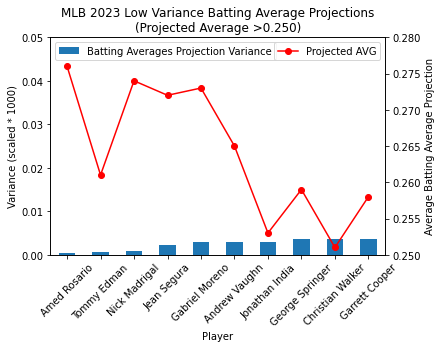

In [20]:
df = df[df.avg_proj_AVG>=0.250]
df.sort_values(by='proj_variance', inplace=True)

#Plot Top 10 Players With Lowest Batting Average Projection Variance
temp = df.copy()

# Scale Variance column by 1000
temp.proj_variance *= 1000

# Rename proj_variance column to something more descriptive for our visual
# Also rename Name to Player
temp.rename({'proj_variance':'Batting Averages Projection Variance',
             'Name':'Player'}, axis=1, inplace=True)

# Make a bar plot for variance
fig = plt.figure()
ax = temp.head(10).plot.bar('Player','Batting Averages Projection Variance')
plt.xticks(rotation=45)
plt.title('MLB 2023 Low Variance Batting Average Projections\n(Projected Average >0.250)')
ax.set_ylabel('Variance (scaled * 1000)')
ax.set_ylim(0,0.05)

# Overlay Projected Batting Averages
ax2 = ax.twinx()
ax2.plot(temp.head(10).Player, temp.head(10).avg_proj_AVG, color="red", marker="o")
ax2.set_ylabel("Average Batting Average Projection")
ax2.set_ylim(0.250,0.280)
ax2.legend(['Projected AVG'], loc='upper right')
ax.legend(loc='upper left')
plt.show()

Alright so now we have the 10 players with the lowest variance among their projections. At the top of the list is Amed Rosario with a solid projected batting average just of 0.275. Similar to how we looked at Jose Iglesias, lets take a closer look at what Rosario has done in his career.

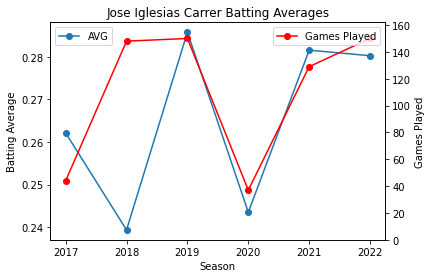

In [21]:
# Read in Amed Rosario game data
import numpy as np
ar = pd.read_csv("https://raw.githubusercontent.com/fantasydatapros/fangraph-data-f6p/main/amed_rosario.csv")
temp = ar.groupby('season',as_index=False).agg({'hits': np.sum,
                          'atBats': np.sum,
                          'AVG': np.mean,
                          'gamesPlayed': np.sum})

ax = temp.plot('season','AVG',marker='o')
ax.set_ylabel('Batting Average')
ax.set_xlabel('Season')
ax.set_title('Jose Iglesias Carrer Batting Averages')
ax2 = ax.twinx()
ax2.plot(temp.season, temp.gamesPlayed, color="red", marker="o")
ax2.set_ylabel("Games Played")
ax2.set_ylim(0, 162)
ax2.legend(['Games Played'], loc='upper right')
ax.legend(loc='upper left');

<Figure size 432x288 with 0 Axes>

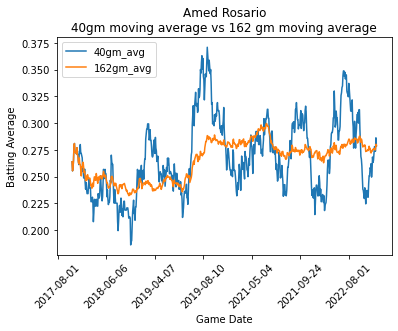

In [22]:
fig = plt.figure()
ar.sort_values(by='game_date', inplace=True)
ar['162gm_avg'] = ar.AVG.rolling(window=162,min_periods=30).mean()
ar['40gm_avg'] = ar.AVG.rolling(window=40, min_periods=30).mean()
ax = ar.plot('game_date',['40gm_avg','162gm_avg'])
ax.set_title('Amed Rosario\n40gm moving average vs 162 gm moving average')
ax.set_ylabel('Batting Average')
ax.set_xlabel('Game Date')
plt.xticks(rotation=45);

Similar to Jose Iglesias, Amed Rosario has had some volatility in his batting average when you compare his 40 game moving average to his 162 game moving average. So why does Rosario have so much less variance in his projections for the upcoming season? If you look at his 162 game moving average, you can see that since the latter part of the 2019 season, his 162 gm moving average has been near or above that .275 mark. Since he has been able to sustain that average over such a long period, it stands to reason that his projections for the upcoming season would be similar across multiple sources. Thus if we consider his last 3 seasons and what he's been able to accomplish batting average wise over time, we should have a fairly high degree of confidence that Rosario should be able to crack that .275 average mark again, or perhaps something higher. 

#Conclusion

In this post, we looked at projection data combined with variance and used Python to help us make high-quality decisions for which players we should target in our drafts / leagues. If you found this type of analysis to be useful and are interested in learning to do this sort of thing yourself, definitely check us out at <a href="https://www.fantasydatapros.com/baseball">https://www.fantasydatapros.com/baseball</a>. Remember to use the code F6P at checkout for $15 off Learn Python with Baseball. Thanks for reading!